In [1]:
# The first four functions are helper functions.
# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [2]:
# Compare feature extraction history with fine tuning history.
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [3]:
# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
# Creates a TensorBoard callback to store log files, which can be used in TensorFlow Hub.
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [5]:
# Prepare dataset
train_dir = "/content/drive/MyDrive/dataset_Transfer_learning(30tau)/dataset_500sr_30tau/training_set"
test_dir = "/content/drive/MyDrive/dataset_Transfer_learning(30tau)/dataset_500sr_30tau/testing_set"
group_validation_dataset_dir = "/content/drive/MyDrive/target_dataset_10_classes(Jasper)"

In [6]:
# It will show how many images/classes there are. 
# Confirm we use 10% training data to train transfer learning models.
walk_through_dir("/content/drive/MyDrive/dataset_Transfer_learning(30tau)/dataset_500sr_30tau/")

There are 2 directories and 0 images in '/content/drive/MyDrive/dataset_Transfer_learning(30tau)/dataset_500sr_30tau/'.
There are 10 directories and 0 images in '/content/drive/MyDrive/dataset_Transfer_learning(30tau)/dataset_500sr_30tau/testing_set'.
There are 0 directories and 200 images in '/content/drive/MyDrive/dataset_Transfer_learning(30tau)/dataset_500sr_30tau/testing_set/flickers'.
There are 0 directories and 200 images in '/content/drive/MyDrive/dataset_Transfer_learning(30tau)/dataset_500sr_30tau/testing_set/interruptions'.
There are 0 directories and 200 images in '/content/drive/MyDrive/dataset_Transfer_learning(30tau)/dataset_500sr_30tau/testing_set/harmonics'.
There are 0 directories and 200 images in '/content/drive/MyDrive/dataset_Transfer_learning(30tau)/dataset_500sr_30tau/testing_set/interruptions_harmonics'.
There are 0 directories and 200 images in '/content/drive/MyDrive/dataset_Transfer_learning(30tau)/dataset_500sr_30tau/testing_set/osc_transients'.
There are 0

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                        label_mode="categorical",
                                        image_size=IMG_SIZE)
                                                                                
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                label_mode="categorical",
                                image_size=IMG_SIZE,
                                shuffle=False)

group_validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(group_validation_dataset_dir,
                                label_mode="categorical",
                                image_size=IMG_SIZE,
                                shuffle=False) # don't shuffle test data for prediction analysis,such as f1 scores.

Found 600 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.


In [8]:
# Create checkpoint callback to save model for later use. 
# For example, the weights of models can return to the state without fine tuning, if the results of fine tuning is less than satisfactory.
checkpoint_path = "10_PQD_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                            save_weights_only=True, # save only the model weights
                            monitor="val_accuracy", # save the model weights which score the best validation accuracy
                            save_best_only=True) # only keep the best model weights on file (delete the rest)

In [9]:
# Setup base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [10]:
# Compile the model
model.compile(loss='categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"])

In [11]:
# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                      epochs=10,
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data,so epochs are faster.
                      callbacks=[checkpoint_callback,
                      create_tensorboard_callback("/content/drive/MyDrive/EfficientNet&Resnet_saved_logs", "EfficientNetB0_feature_extraction_without_fine_tuning_dataset_500sr_30tau")]) # save best model weights to file

Saving TensorBoard log files to: /content/drive/MyDrive/EfficientNet&Resnet_saved_logs/EfficientNetB0_feature_extraction_without_fine_tuning_dataset_500sr_30tau/20221021-221601
Epoch 1/10
19/19 [==============================] - 39s 983ms/step - loss: 1.8961 - accuracy: 0.3417 - val_loss: 1.1533 - val_accuracy: 0.9479
Epoch 2/10
19/19 [==============================] - 1s 68ms/step - loss: 1.2341 - accuracy: 0.6950 - val_loss: 0.6770 - val_accuracy: 1.0000
Epoch 3/10
19/19 [==============================] - 1s 53ms/step - loss: 0.9281 - accuracy: 0.7817 - val_loss: 0.5300 - val_accuracy: 1.0000
Epoch 4/10
19/19 [==============================] - 1s 54ms/step - loss: 0.7587 - accuracy: 0.8167 - val_loss: 0.4247 - val_accuracy: 1.0000
Epoch 5/10
19/19 [==============================] - 1s 36ms/step - loss: 0.6506 - accuracy: 0.8500 - val_loss: 0.4262 - val_accuracy: 1.0000
Epoch 6/10
19/19 [==============================] - 1s 38ms/step - loss: 0.5844 - accuracy: 0.8667 - val_loss: 0.342

In [12]:
# Evaluate model with all test data.
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

63/63 [==============================] - 44s 702ms/step - loss: 0.4197 - accuracy: 0.8775


[0.4197038412094116, 0.8774999976158142]

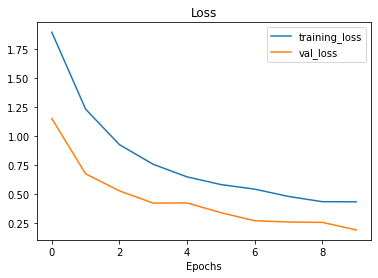

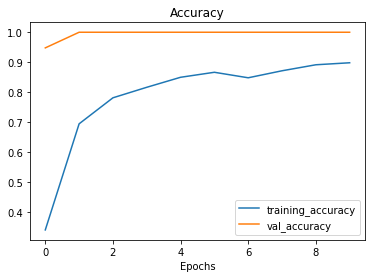

In [13]:
plot_loss_curves(history_all_classes_10_percent)

In [14]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 False
global_average_pooling_layer True
output_layer True


In [15]:
# Save model to drive so it can be used later
model.save("/content/drive/MyDrive/EfficientNet&Resnet_saved_models_without_fine_tuning/dataset_500sr_30tau")

In [16]:
# Make predictions with model
pred_probs = model.predict(group_validation_dataset, verbose=1) # set verbosity to see how long it will take 

94/94 [==============================] - 54s 562ms/step


In [17]:
# How many predictions are there?
len(pred_probs)

3000

In [18]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 10
What prediction probability sample 0 looks like:
 [0.6441033  0.00176499 0.00556965 0.00067775 0.00364318 0.03712943
 0.00381086 0.00467414 0.27867222 0.01995457]
The class with the highest predicted probability by the model for sample 0: 0


In [19]:
# Print some sample predictions to generally see the accuracy of models.
print(f"The class with the highest predicted probability by the model for sample 50: {pred_probs[50].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 150: {pred_probs[150].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 250: {pred_probs[250].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 350: {pred_probs[350].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 450: {pred_probs[450].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 550: {pred_probs[550].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 650: {pred_probs[650].argmax()}")
print(f"The class with the highest predicted probability by the model for sample 750: {pred_probs[750].argmax()}")

The class with the highest predicted probability by the model for sample 50: 0
The class with the highest predicted probability by the model for sample 150: 0
The class with the highest predicted probability by the model for sample 250: 0
The class with the highest predicted probability by the model for sample 350: 3
The class with the highest predicted probability by the model for sample 450: 1
The class with the highest predicted probability by the model for sample 550: 3
The class with the highest predicted probability by the model for sample 650: 2
The class with the highest predicted probability by the model for sample 750: 2


In [20]:
# Due to the nature of the softmax activation function, the sum of each of the prediction probabilities for a single sample will be 1 (or at least very close to 1).
pred_probs[0].sum()

1.0000001

In [21]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([0, 0, 0, 0, 8, 0, 0, 0, 8, 0])

In [22]:
# To get the test dataset labels we can unravel our test_data object (which is in the form of a tf.data.Dataset) using the unbatch() method.
y_labels = []
for images, labels in group_validation_dataset.unbatch(): # unbatch the group validation dataset and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [23]:
# How many labels are there? (should be the same as how many prediction probabilities we have)
len(y_labels)

3000

In [24]:
# The following confusion matrix code is a remix of Scikit-Learn's plot_confusion_matrix function.
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [25]:
# Get the class names
class_names = group_validation_dataset.class_names
class_names

['flickers',
 'harmonics',
 'interruptions',
 'interruptions_harmonics',
 'osc_transients',
 'sags',
 'sags_harmonics',
 'spikes',
 'swells',
 'swells_harmonics']

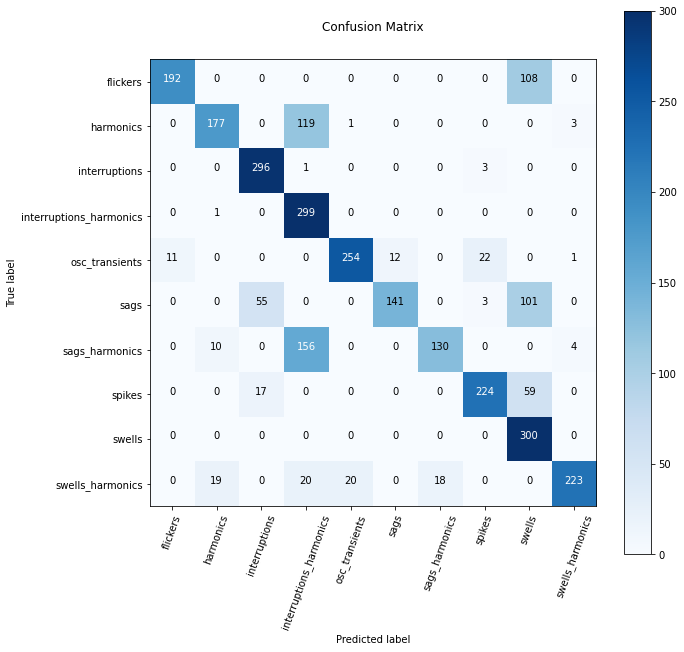

In [26]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
          y_pred=pred_classes,
          classes=class_names,
          figsize=(10, 10),
          text_size=10,
          norm=False,
          savefig=True)

In [27]:
# Print evaluation results of the model, including macro f1 scores.
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.95      0.64      0.76       300
           1       0.86      0.59      0.70       300
           2       0.80      0.99      0.89       300
           3       0.50      1.00      0.67       300
           4       0.92      0.85      0.88       300
           5       0.92      0.47      0.62       300
           6       0.88      0.43      0.58       300
           7       0.89      0.75      0.81       300
           8       0.53      1.00      0.69       300
           9       0.97      0.74      0.84       300

    accuracy                           0.75      3000
   macro avg       0.82      0.75      0.74      3000
weighted avg       0.82      0.75      0.74      3000

